In [1]:
push!(LOAD_PATH, "..")
using ASE
using MatSciPy
using PyPlot
using PyCall
using TightBinding

In [2]:
# some parameters

# displacement of one atom
δ = 0.2
# temperature
TEMPE = 300

300

## 1a. Carbon_perfect_0T

In [3]:
at = bulk("C"; cubic=true)
at = repeat(at, (2, 2, 2))
set_pbc!(at, [true, true, true])
X = positions(at)

#plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
#plot3D(X[1,1:1], X[2,1:1], X[3,1:1], "ro")
print(length(at))
print(cell(at))

64[7.14 0.0 0.0
 0.0 7.14 0.0
 0.0 0.0 7.14]

In [6]:
import NRLTB
reload("TightBinding")
reload("NRLTB")

set_pbc!(at, [true, true, true])
tbm = NRLTB.NRLTBModel(elem = NRLTB.C_sp)
tbm.nkpoints = (4,4,8)

# take a very low temperature  T=300 to approximate the fermi level at 0 temperature
K, E = TightBinding.band_structure_all(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc0 = TightBinding.forces(at, tbm)
print(norm(frc0[:],Inf))
# print(tbm.eF)

1.5086660922696097e-15

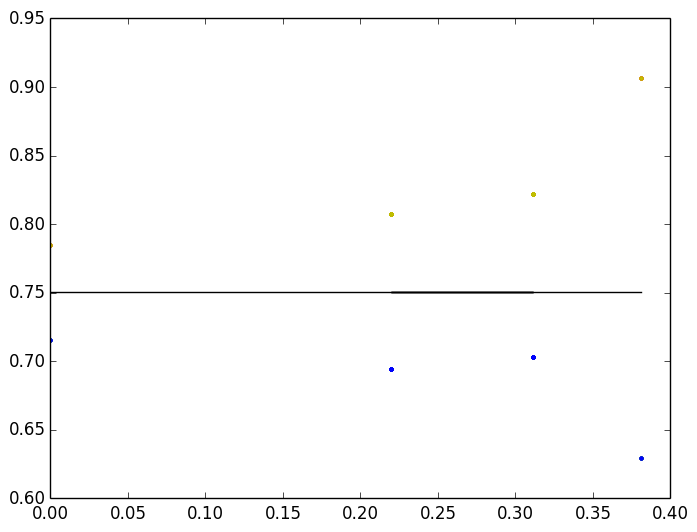

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x93ab250>

In [41]:
n = size(K,2)
kk = zeros(n)
for k = 1:n
    kk[k] = norm(K[:,k])
end

plot(kk, E[1,:][:], "g.")
hold
plot(kk, E[2,:][:], "b.")
plot(kk, E[3,:][:], "r.")
plot(kk, E[4,:][:], "y.")
plot(kk, ones(n)*tbm.eF, "k-" )

In [6]:
# move one atom and test the force

X[1,1] += δ
set_positions!(at, X)

# one nees to compute Fermi-level again
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc1 = TightBinding.forces(at, tbm)

3x512 Array{Float64,2}:
 -0.615736     0.146466   -0.0213164  …   0.000228668  -0.00026792 
 -5.0256e-16   0.0321791  -0.011036       0.000186522  -0.00113009 
  6.27914e-16  0.0321791  -0.011036      -0.000127991  -0.000671241

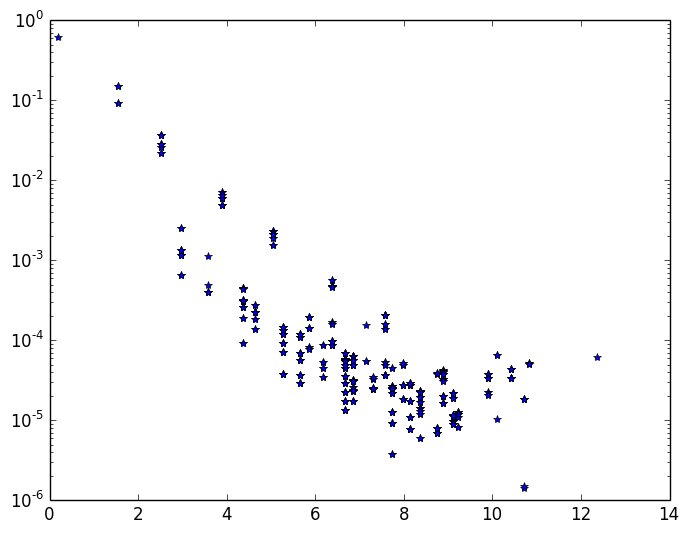

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x4ed0890>

In [7]:
L = cell(at)[1,1]

F = zeros(length(at))
Z = zeros(length(at))  # periodic distance

for j = 1:length(at)
    F[j] = norm(frc1[:,j])
    Z[j] = min( norm(X[:,j]), norm(X[:,j]-[L, 0, 0]), 
                norm(X[:,j]-[0, L, 0]), norm(X[:,j]-[0, 0, L]), 
                norm(X[:,j]-[0, L, L]), norm(X[:,j]-[L, 0, L]), 
                norm(X[:,j]-[L, L, 0]), norm(X[:,j]-[L, L, L]) )
end
semilogy(Z, F, "*")

## 1b. Carbon with periodic boundary at finite T
### $\beta$=300 -> $\beta$=10

In [18]:
FT = 10.0  # room temperature

10.0

In [20]:
at = bulk("C"; cubic=true)
at = repeat(at, (4, 4, 4))
set_pbc!(at, [true, true, true])
X = positions(at)

#plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
#plot3D(X[1,1:1], X[2,1:1], X[3,1:1], "ro")
print(length(at))
print(cell(at))

512[14.28 0.0 0.0
 0.0 14.28 0.0
 0.0 0.0 14.28]

In [21]:
import NRLTB
reload("TightBinding")
reload("NRLTB")

tbm = NRLTB.NRLTBModel(elem = NRLTB.C_sp)
tbm.nkpoints = (2,2,2)

# take a very low temperature  T=300 to approximate the fermi level at 0 temperature
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = FT
TightBinding.update_eF!(at, tbm)

frc0 = TightBinding.forces(at, tbm)
print(norm(frc0[:],Inf))

3.2187689518130424e-15

In [22]:
# move one atom and test the force

X[1,1] += δ
set_positions!(at, X)

# one nees to compute Fermi-level again
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = FT
TightBinding.update_eF!(at, tbm)

frc1 = TightBinding.forces(at, tbm)

3x512 Array{Float64,2}:
 -1.03689      0.157351    0.00678014  …   0.000288299  -0.00161332
 -1.32949e-17  0.0907936  -0.0165347      -0.00101253    0.00384273
  9.66118e-17  0.0907936  -0.0165347      -4.51978e-5   -0.00307673

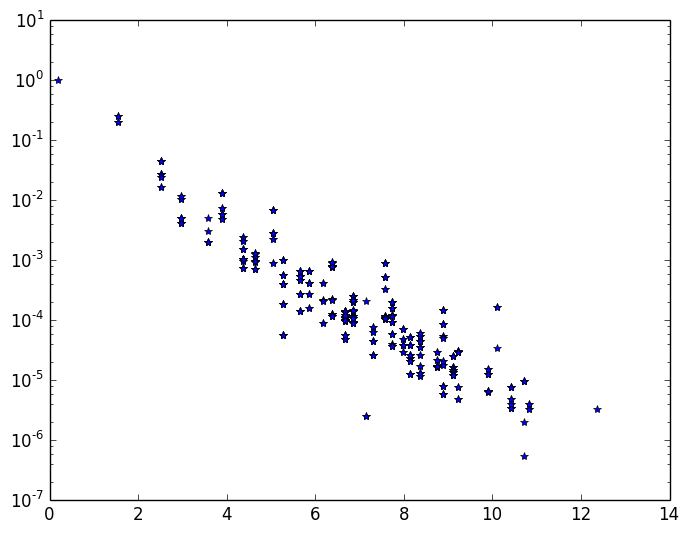

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x978add0>

In [24]:
L = cell(at)[1,1]

F = zeros(length(at))
Z = zeros(length(at))  # distance

for j = 1:length(at)
    F[j] = norm(frc1[:,j] - frc0[:,j])
    Z[j] = min( norm(X[:,j]), norm(X[:,j]-[L, 0, 0]), 
                norm(X[:,j]-[0, L, 0]), norm(X[:,j]-[0, 0, L]), 
                norm(X[:,j]-[0, L, L]), norm(X[:,j]-[L, 0, L]), 
                norm(X[:,j]-[L, L, 0]), norm(X[:,j]-[L, L, L]) )
end
semilogy(Z, F, "*")

## 1c. Carbon with open boundary at 0T
### one can only test the force differences

In [8]:
at = bulk("C"; cubic=true)
at = repeat(at, (4, 4, 4))
set_pbc!(at, [false, false, false])
X = positions(at)

#plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
#plot3D(X[1,1:1], X[2,1:1], X[3,1:1], "ro")
print(length(at))
print(cell(at))

512[14.28 0.0 0.0
 0.0 14.28 0.0
 0.0 0.0 14.28]

In [9]:
import NRLTB
reload("TightBinding")
reload("NRLTB")

tbm = NRLTB.NRLTBModel(elem = NRLTB.C_sp)
tbm.nkpoints = (0,0,0)

# kT = 10
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc0 = TightBinding.forces(at, tbm)
# print(norm(frc0[:],Inf))

3x512 Array{Float64,2}:
 0.513549  0.0700791   2.08954   -0.681569  …  -0.84488  0.732973  -0.84488
 0.513549  0.0700791  -0.703459   0.114222     -1.67644  0.732973  -0.84488
 0.513549  0.0700791  -0.703459   0.114222     -0.84488  0.10248   -1.67644

In [10]:
# move one atom and test the force

X[1,1] += δ
set_positions!(at, X)

# one nees to compute Fermi-level again
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc1 = TightBinding.forces(at, tbm)

3x512 Array{Float64,2}:
 0.406524   0.159525    1.93728  -0.493396  …  -0.837587  0.724948  -0.837587
 0.415729  -0.0840711  -0.55614   0.130995     -1.67951   0.734602  -0.836769
 0.415729  -0.0840711  -0.55614   0.130995     -0.836769  0.123091  -1.67951 

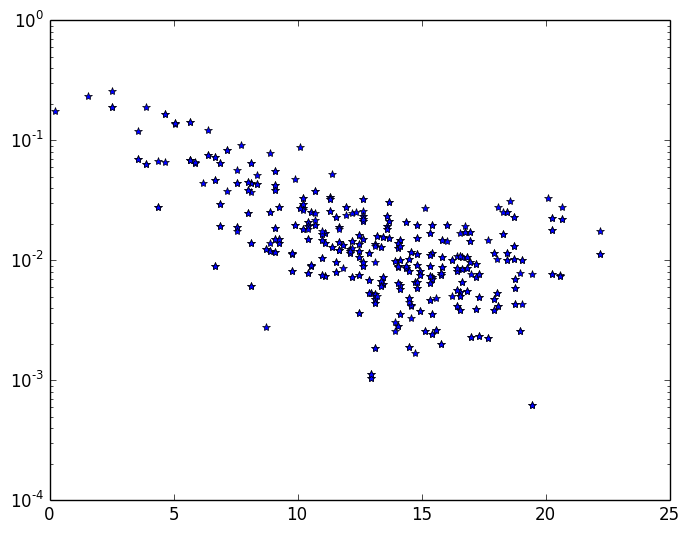

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x76df750>

In [11]:
L = cell(at)[1,1]

F = zeros(length(at))
Z = zeros(length(at))  # distance

for j = 1:length(at)
    F[j] = norm(frc1[:,j] - frc0[:,j])
    Z[j] = norm(X[:,j])
end
semilogy(Z, F, "*")

## 1d. Carbon with open boundary at finite T
### $\beta=300$ -> $\beta=10$

In [44]:
at = bulk("C"; cubic=true)
at = repeat(at, (4, 4, 4))
set_pbc!(at, [false, false, false])
X = positions(at)

#plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
#plot3D(X[1,1:1], X[2,1:1], X[3,1:1], "ro")
print(length(at))
print(cell(at))

512[14.28 0.0 0.0
 0.0 14.28 0.0
 0.0 0.0 14.28]

In [45]:
import NRLTB
reload("TightBinding")
reload("NRLTB")

tbm = NRLTB.NRLTBModel(elem = NRLTB.C_sp)
tbm.nkpoints = (0,0,0)

# kT=10
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = FT
TightBinding.update_eF!(at, tbm)

frc0 = TightBinding.forces(at, tbm)

3x512 Array{Float64,2}:
 0.643637  -0.403401   1.02776   …  -0.815585    0.430678  -0.815585  
 0.643637  -0.403401  -0.117811     -0.00881194  0.430678  -0.815585  
 0.643637  -0.403401  -0.117811     -0.815585    0.068458  -0.00881194

In [46]:
# move one atom and test the force

X[1,1] += δ
set_positions!(at, X)

# one nees to compute Fermi-level again
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = FT
TightBinding.update_eF!(at, tbm)

frc1 = TightBinding.forces(at, tbm)

3x512 Array{Float64,2}:
 0.719109  -0.393344   1.05659   …  -0.815821    0.430694  -0.815821  
 0.725245  -0.383588  -0.096886     -0.00827442  0.430694  -0.815821  
 0.725245  -0.383588  -0.096886     -0.815821    0.06855   -0.00827442

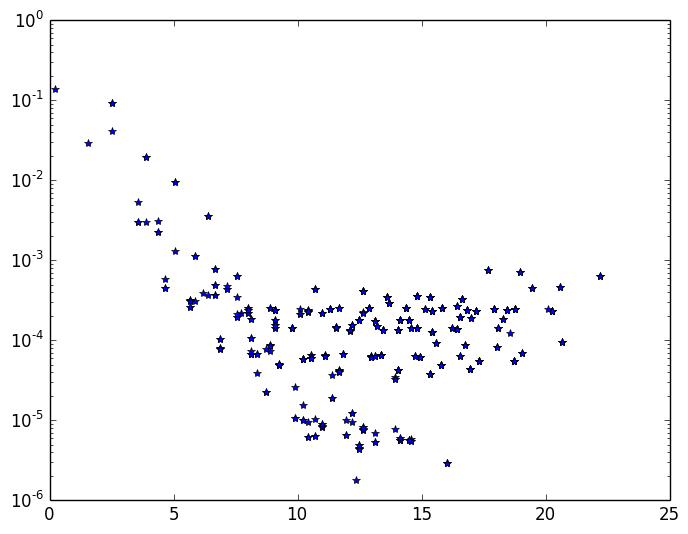

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x8505150>

In [47]:
L = cell(at)[1,1]

F = zeros(length(at))
Z = zeros(length(at))  # distance

for j = 1:length(at)
    F[j] = norm(frc1[:,j] - frc0[:,j])
    Z[j] = norm(X[:,j])
end
semilogy(Z, F, "*")

## 2. Carbon with a vacancy

In [51]:
using PyCall
@pyimport ase

X = positions(at)
na = length(at)
Y = zeros(3,na-1)
Y = X[:,1:na-1]

at_vac = ASEAtoms( ase.Atoms("C511") )
set_cell!(at_vac, cell(at))
set_positions!(at_vac, Y)
set_pbc!(at_vac, [true, true, true])
tbm.nkpoints = (2,2,2)

X_vac = positions(at_vac)
# plot3D(X_vac[1,:][:], X_vac[2,:][:], X_vac[3,:][:], "b.")
print(length(at_vac))

511

In [60]:
# fix fermi level by perfect lattice
# K, E = TightBinding.band_structure(at_vac, tbm)
# tbm.fixed_eF = false
# tbm.smearing.beta = TEMPE
# TightBinding.update_eF!(at_vac, tbm)

tbm.eF = 0.7502348995952292

# force
frc2 = TightBinding.forces(at_vac, tbm)

3x511 Array{Float64,2}:
 0.00141818  0.000114516  -2.12042e-6  …  -0.00844651   -0.0816644
 0.00141818  0.000114516  -8.16676e-6     -0.000701927  -0.0816644
 0.00269872  3.66628e-5   -7.04044e-6      0.000701927  -0.0816644

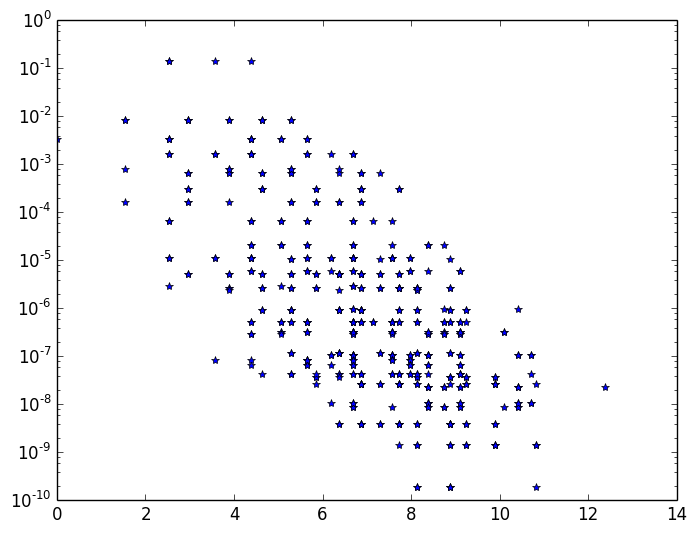

4-element Array{Float64,1}:
  0.0    
 14.0    
  1.0e-10
  1.0    

In [65]:
L = cell(at)[1,1]

F = zeros(length(at_vac))
Z = zeros(length(at_vac))  # periodic distance

for j = 1:length(at_vac)
    F[j] = norm(frc2[:,j])
    Z[j] = # norm(Y[:,j])
    min( norm(Y[:,j]), norm(Y[:,j]-[L, 0, 0]), 
                norm(Y[:,j]-[0, L, 0]), norm(Y[:,j]-[0, 0, L]), 
                norm(Y[:,j]-[0, L, L]), norm(Y[:,j]-[L, 0, L]), 
                norm(Y[:,j]-[L, L, 0]), norm(Y[:,j]-[L, L, L]) )
end
semilogy(Z, F, "*")
axis([0,14,1.0e-10,1])

In [54]:
import NRLTB
reload("TightBinding")
reload("NRLTB")
tbm = NRLTB.NRLTBModel(elem = NRLTB.C_sp)

set_pbc!(at_vac, [true, true, true])
tbm.nkpoints = (2,2,2)

K, E = TightBinding.band_structure(at_vac, tbm)

(
3x8 Array{Float64,2}:
 0.0  0.219999  0.0       0.219999  0.0       0.219999  0.0       0.219999
 0.0  0.0       0.219999  0.219999  0.0       0.0       0.219999  0.219999
 0.0  0.0       0.0       0.0       0.219999  0.219999  0.219999  0.219999,

8x8 Array{Float64,2}:
 0.689695  0.69424   0.69424   0.702852  …  0.702852  0.702852  0.629771
 0.724147  0.696622  0.696622  0.702852     0.702852  0.702852  0.68833 
 0.724147  0.696622  0.696622  0.717791     0.717791  0.717791  0.68833 
 0.724147  0.712125  0.712125  0.717791     0.717791  0.717791  0.68833 
 0.787842  0.807325  0.807325  0.821823     0.821823  0.821823  0.906829
 0.787842  0.81252   0.81252   0.821823  …  0.821823  0.821823  0.906829
 0.787842  0.883237  0.883237  0.826736     0.826736  0.826736  0.906829
 0.873099  0.883242  0.883242  0.826736     0.826736  0.826736  0.90692 )

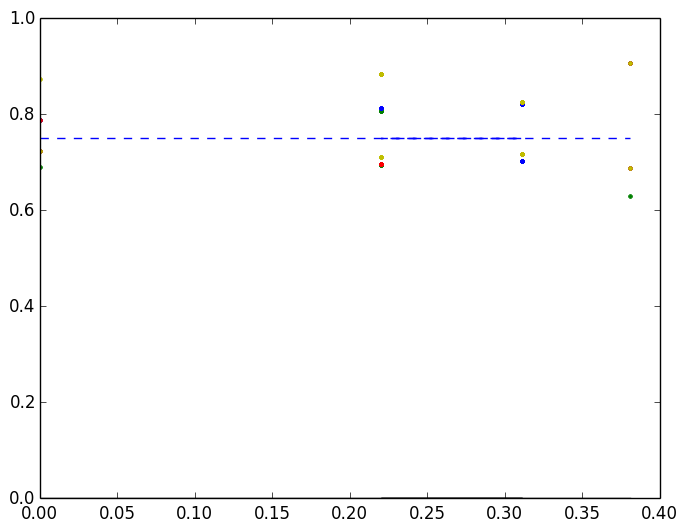

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0xe218e10>

In [58]:
n = size(K,2)
kk = zeros(n)
for k = 1:n
    kk[k] = norm(K[:,k])
end

plot(kk, E[1,:][:], "g.")
plot(kk, E[2,:][:], "b.")
plot(kk, E[3,:][:], "r.")
plot(kk, E[4,:][:], "y.")
plot(kk, E[5,:][:], "g.")
plot(kk, E[6,:][:], "b.")
plot(kk, E[7,:][:], "r.")
plot(kk, E[8,:][:], "y.")
plot(kk, ones(n)*tbm.eF, "k-" )
plot(kk, ones(n)*0.7502348995952292, "--" )

## 3. Aluminimu

In [118]:
at = bulk("Al"; cubic=true)
at = repeat(at, (4, 4, 4))
set_pbc!(at, [true, true, true])
X = positions(at)

#plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")
#plot3D(X[1,1:1], X[2,1:1], X[3,1:1], "ro")
print(length(at))
print(cell(at))

256[16.2 0.0 0.0
 0.0 16.2 0.0
 0.0 0.0 16.2]

In [119]:
import NRLTB
reload("TightBinding")
reload("NRLTB")

set_pbc!(at, [true, true, true])
tbm = NRLTB.NRLTBModel(elem = NRLTB.C_sp)
tbm.nkpoints = (2,2,2)

# take a very low temperature  T=300 to approximate the fermi level at 0 temperature
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc0 = TightBinding.forces(at, tbm)
print(norm(frc0[:],Inf))

1.9335231536307556e-14

In [120]:
# move one atom and test the force

X[1,1] += δ
set_positions!(at, X)

# one nees to compute Fermi-level again
K, E = TightBinding.band_structure(at, tbm)
tbm.fixed_eF = false
tbm.smearing.beta = TEMPE
TightBinding.update_eF!(at, tbm)

frc1 = TightBinding.forces(at, tbm)

3x256 Array{Float64,2}:
 -0.458136      0.137054    0.0420122    …  -0.0400408   -0.0400408 
 -1.95517e-15  -0.0313596  -3.17257e-15     -0.0093768    0.00881678
 -1.39224e-16  -0.0313596   0.0285193        0.00881678  -0.0093768 

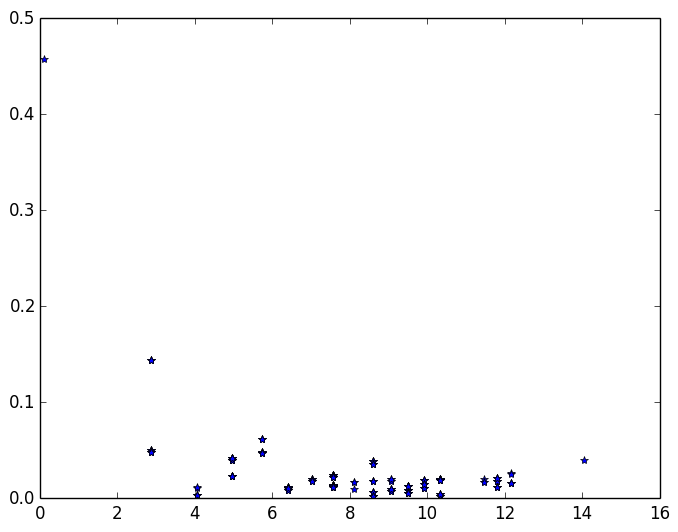

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x27c0c7d0>

In [121]:
L = cell(at)[1,1]

F = zeros(length(at))
Z = zeros(length(at))  # periodic distance

for j = 1:length(at)
    F[j] = norm(frc1[:,j])
    Z[j] = min( norm(X[:,j]), norm(X[:,j]-[L, 0, 0]), 
                norm(X[:,j]-[0, L, 0]), norm(X[:,j]-[0, 0, L]), 
                norm(X[:,j]-[0, L, L]), norm(X[:,j]-[L, 0, L]), 
                norm(X[:,j]-[L, L, 0]), norm(X[:,j]-[L, L, L]) )
end
plot(Z, F, "*")

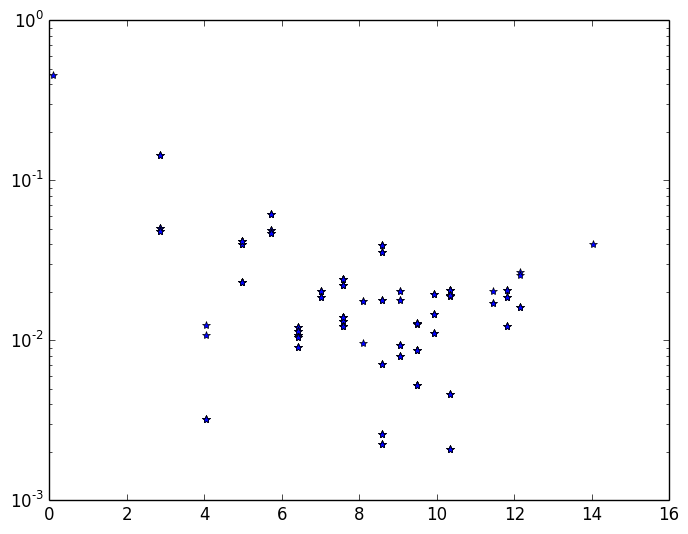

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x27c26d10>

In [122]:
semilogy(Z, F, "*")